In [29]:
#状態空間モデル（トレンド、季節性込み）、statsmodel利用
#データを生成する。

import pandas as pd
import numpy as np
from scipy import stats

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from matplotlib import pylab as plt
import seaborn as sns
sns.set()

#from matplotlib import rcParams
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = 'Meiryo'

In [30]:
# 乱数の種
np.random.seed(1)
sim_size=100
# ドリフト成分
delta = np.zeros(sim_size)
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# 水準成分
mu_trend = np.zeros(sim_size)

In [31]:
for t in range(2, sim_size):
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]
    mu_trend[t] = mu_trend[t - 1] + delta[t] + \
                  stats.norm.rvs(loc=0, scale=10, size=1)[0]

# 観測値
y_trend = mu_trend + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [32]:
trend_df = pd.DataFrame({'delta':delta, 'mu':mu_trend, 'y':y_trend},
                        index=pd.date_range(start='2000-01-01', periods=sim_size, freq='MS'))

<Axes: >

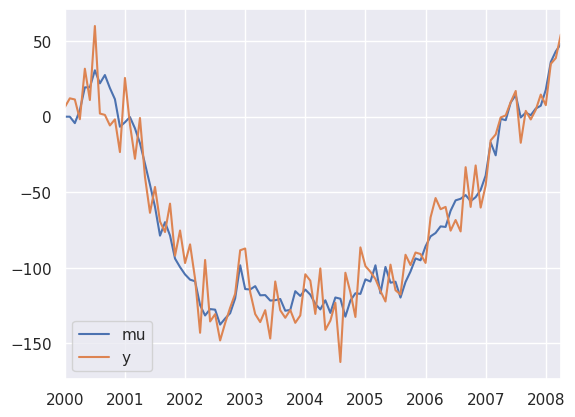

In [33]:
trend_df[['mu','y']].plot()

In [34]:
#推定
mod_trend = tsa.UnobservedComponents(
    trend_df['y'],
    level='local linear trend',
)

res_trend = mod_trend.fit(
    method='nm',
    maxiter=2000
)

Optimization terminated successfully.
         Current function value: 4.332766
         Iterations: 129
         Function evaluations: 239


<Axes: >

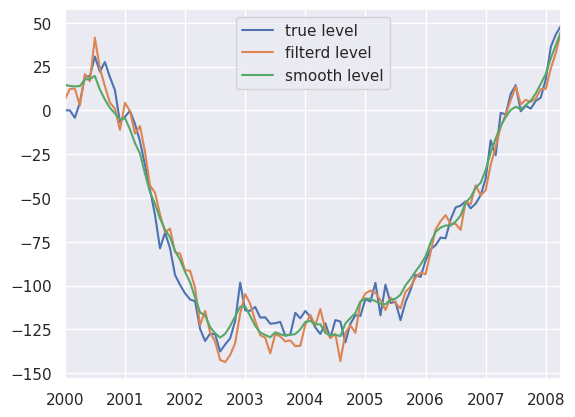

In [35]:
plot_df = pd.DataFrame({'true level':trend_df.mu,
                        'filterd level':res_trend.level['filtered'],
                        'smooth level':res_trend.level['smoothed']})

plot_df.plot()

In [36]:
#季節性のある基本構造時系列モデル
#データの生成
s = np.zeros(sim_size)
s_12 = np.array([-30, -75, -45, -15, 5, 30, 40, 60, 25, 15, 5, -15])

In [37]:
s[0:12] = s_12
for t in range(12, sim_size):
    s[t] = stats.norm.rvs(loc=0, scale=2, size=1)[0] - \
           np.sum(s[(t - 11):t])

# 状態
alpha = mu_trend + s

# 観測値
y_bsts = alpha + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [38]:
bsts_df = pd.DataFrame({'delta':delta, 'mu':mu_trend, 's':s, 'alpha':alpha, 'y':y_bsts},
                       index=pd.date_range(start='2000-01-01',periods=sim_size, freq='MS'))

In [39]:
bsts_df.head(10)

,delta,mu,s,alpha,y
2000-01-01,0.000000,0.000000,-30.0,-30.000000,-32.762645
2000-02-01,1.624345,0.000000,-75.0,-75.000000,-76.739778
2000-03-01,1.012589,-4.269129,-45.0,-49.269129,-51.901013
2000-04-01,-0.060380,4.324568,-15.0,-10.675432,-24.684152
2000-05-01,-2.361918,19.410767,5.0,24.410767,16.415462
2000-06-01,-3.123125,19.478033,30.0,49.478033,28.079702
2000-07-01,-3.372496,30.726617,40.0,70.726617,97.246016
2000-08-01,-5.432636,22.069808,60.0,82.069808,74.939215
2000-09-01,-5.816691,27.590812,25.0,52.590812,59.754965
2000-10-01,-6.916582,18.949948,15.0,33.949948,18.621659


<Axes: >

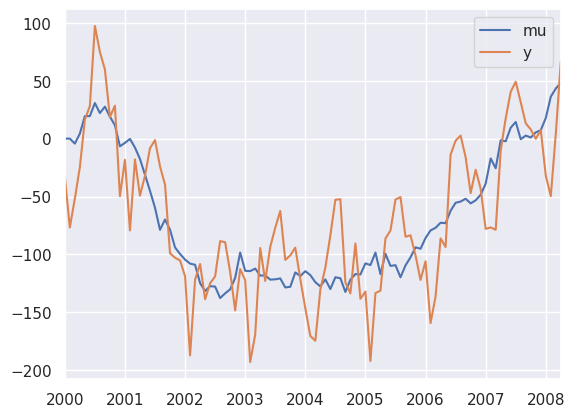

In [40]:
bsts_df[['mu', 'y']].plot()

In [41]:
#季節性とトレンドのあるデータの状態推定
mod_bsts = tsa.UnobservedComponents(
    bsts_df['y'], level='local linear trend', seasonal=12
)

res_bsts = mod_bsts.fit(
    method='nm',
    maxiter=2000
)

Optimization terminated successfully.
         Current function value: 4.080447
         Iterations: 185
         Function evaluations: 323


<Axes: >

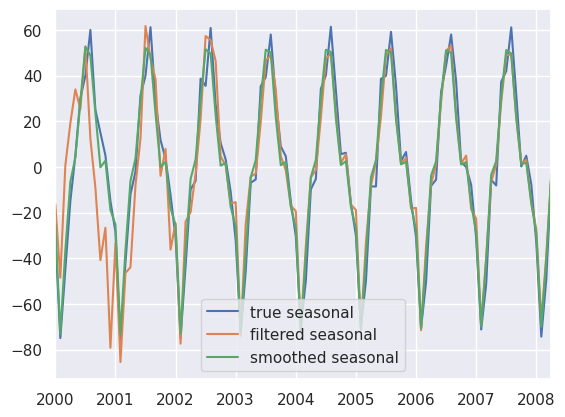

In [42]:
#季節成分の可視化
plot_df = pd.DataFrame({
    'true seasonal': bsts_df['s'],
    'filtered seasonal': res_bsts.seasonal['filtered'],
    'smoothed seasonal': res_bsts.seasonal['smoothed']
})

plot_df.plot()

<Axes: >

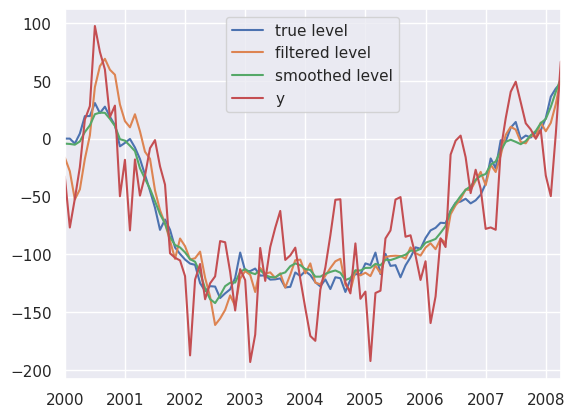

In [43]:
#季節成分を除外して可視化
plot_df = pd.DataFrame({
    'true level': bsts_df['mu'],
    'filtered level': res_bsts.level['filtered'],
    'smoothed level': res_bsts.level['smoothed'],
    'y': bsts_df['y']
})

plot_df.plot()

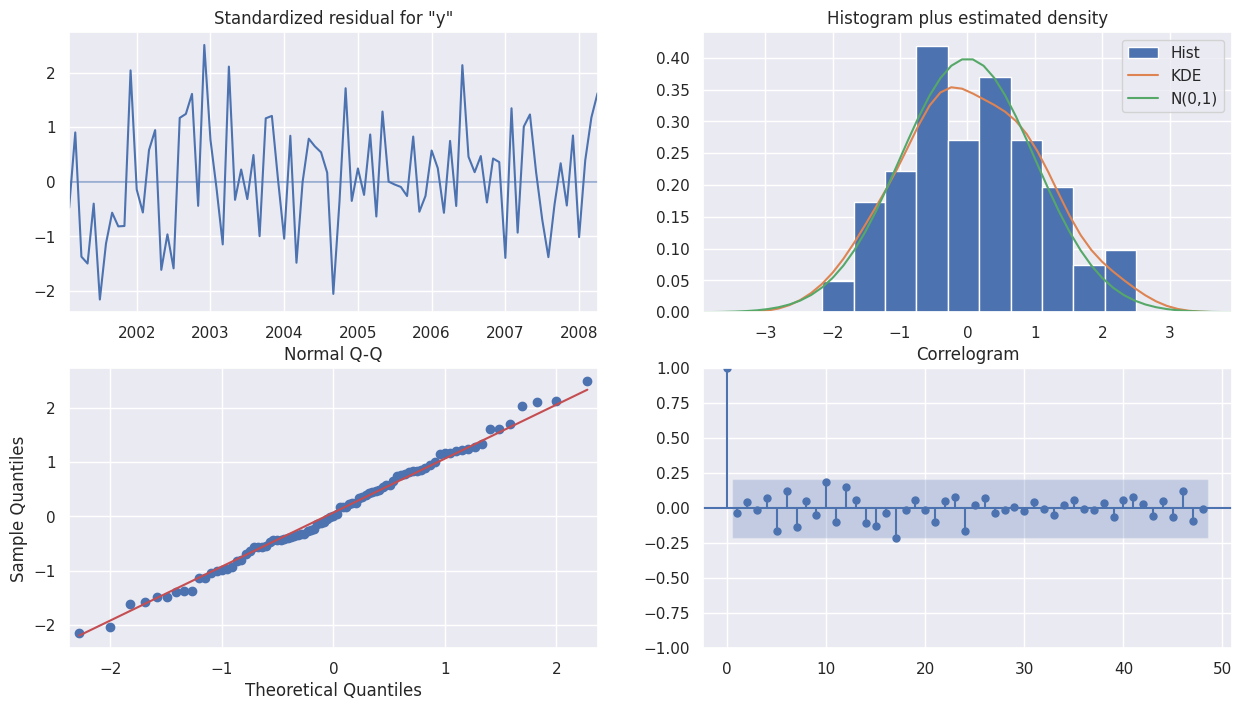

In [44]:
#残差診断
_ = res_bsts.plot_diagnostics(lags=48,figsize=(15,8))

<Axes: >

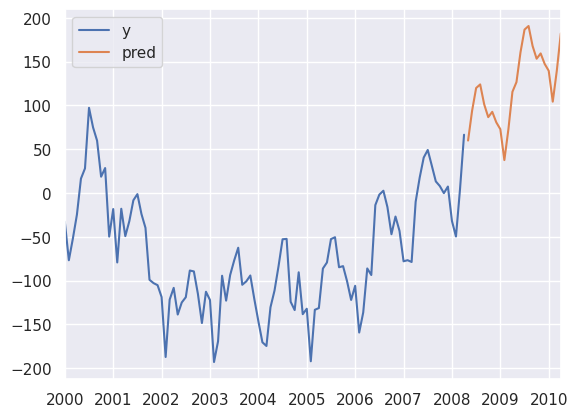

In [45]:
#24時点先までの予測
pred = res_bsts.forecast(24)

plot_df = pd.DataFrame({
    'y': bsts_df['y'],
    'pred': pred
    })

plot_df.plot()